In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import scipy
from scipy.stats import pearsonr, spearmanr
import scipy.cluster.hierarchy as sch

from tqdm import tqdm

# Functions

## Data processing functions

In [2]:
def import_data():
    # Import data

    col_names = pd.read_csv("communities_names.csv", header = None)
    list_of_column_names = []

    for index, row_data in col_names.iterrows():
        list_of_column_names.append(str(row_data[0]))

    data = pd.read_csv("communities_data.csv", names = list_of_column_names)

    # Remove categorical columns 
    # 1: county and communities have many missing values
    # 2: communityname would be a direct indicator of crime and should be removed
    # 3: state is not that important

    data.drop(labels = ["state", "county", "community", "communityname"],axis = 1, inplace = True)

    # We also remove the fold-column since this is only present for reproducing article findings

    data.drop(labels = ["fold"],axis = 1, inplace = True)

    # Drop columns with missing data
    col_names_missing_vals = pd.read_csv("communities_names_missing.csv", header = None)
    list_of_column_names_missing_vals = []

    for index, row_data in col_names_missing_vals.iterrows():
        list_of_column_names_missing_vals.append(str(row_data[0]))


    data.drop(labels = list_of_column_names_missing_vals,axis = 1, inplace = True)    
    
    # Make data_init
    data_init = data.copy()
    
    # Make a categorical column for blackness where we set a threshold (just for visualization purposes)
    racepctblack = np.asarray(data.racepctblack)
    threshold = 0.15 # Previously 0.4
    IsBlack = [1 if x>threshold else 0 for x in racepctblack]
    data["IsBlack"] = IsBlack

    # Make a categorical column for crime
    crime_rate = np.asarray(data.ViolentCrimesPerPop)
    threshold_crime = np.quantile(data_init.ViolentCrimesPerPop, 0.70)
    HighCrime = [1 if x>threshold_crime else 0 for x in crime_rate]
    data["HighCrime"] = HighCrime
    
    # Make a full dataframe where we have not removed the protected columns or the label
    data_full = data.copy()
    
    # Remove protected features and put into separate dataframe
    # Note: this includes all racepct-columns (black, white, asian, hipspanic), since one can be somewhat derived from the others
    protected_cols = ["IsBlack", "racepctblack", "racePctWhite", "racePctAsian", "racePctHisp"]
    data_protected = pd.concat([data.pop(x) for x in protected_cols], axis=1)
    
    # Remove y column (the label)
    y_cols = ["ViolentCrimesPerPop", "HighCrime"]
    data_y = pd.concat([data.pop(x) for x in y_cols], axis=1)
    
    return data_init, data_full, data, data_protected, data_y


In [3]:
def scaling_func(scaling_obj):
    def scale(x_train, x_test):
        scaler = scaling_obj().fit(x_train)
        return scaler.transform(x_train), scaler.transform(x_test)
    return scale

In [4]:
def reproject_features(data, protected_cols, nonprotected_cols):
    """
    generate a fair representation of nonprotected columns which are independent from any columns in protected_cols
    data: a data frame
    protected_cols: list of strings, the protected columns
    nonprotected_col: string, all other data columns 

    NOTE: this function assumes the data is already centered 
    """
    # make a copy of data
    df = data.copy()
    # Protected features
    protect = df[protected_cols].values
    # extract data about nonprotected columns
    debiased_nonprotect = df[nonprotected_cols].values
    # crease an orthonormal basis
    base_protect = scipy.linalg.orth(protect)
    for j in range(debiased_nonprotect.shape[1]):
        debiased_nonprotect[:,
                            j] -= base_protect @ base_protect.T @ debiased_nonprotect[:, j]
    return debiased_nonprotect


def reproject_features_w_regul(data, protected_cols, nonprotected_cols, lambda_):
    """
    generate a fair representation of nonprotected columns which are independent from any columns in protected_cols
    dat_: a data frame
    protected_cols: list of strings, the protected columns
    nonprotected_col: string, all other data columns 
    lambda_: float number between 0 and 1, 0 means totally fair; 1 means same as raw data
    """

    # run the normal reproject_features function
    r = reproject_features(data, protected_cols, nonprotected_cols)

    # extract data about nonprotected variables
    nonprotect = data[nonprotected_cols].values
    # standardize columns

    return r + lambda_*(nonprotect - r)


def debias_data(protected_cols, nonprotected_cols, lambda_=0):
    """
    Debias data, data pipeline

    Arguments
    ---------
    protected_cols: list of strings, 
        the protected columns

    nonprotected_col: String, 
        all other data columns 

    Returns
    -------
    Function(X_train, X_test) => X_train_r, X_test_r
        A fucntion which takes X_train, X_test and returns the reprojected versions of X_train, X_test

    """
    def call(X_train, X_test):
        # Standard scale the data data
        _mean = np.mean(X_train, axis=0)
        _std = np.std(X_train, ddof=1, axis=0)
        X_train_scaled = (X_train - _mean)/_std
        X_test_scaled = (X_test - _mean)/_std
        # reproject features
        X_train_r = reproject_features_w_regul(
            X_train_scaled, protected_cols, nonprotected_cols, lambda_)
        X_test_r = reproject_features_w_regul(
            X_test_scaled, protected_cols, nonprotected_cols, lambda_)
        return X_train_r, X_test_r
    return call


## Model evaluation functions

In [5]:
def test_model(model, X, y, kfold, scaler=None, model_params={}):
    """
    Test models using some cross validation method and with a scaling method.

    Parameters
    ----------
    model : sklearn model object. 
        This object must not be instansiated

    X : pandas.Dataframe
        df containing all the features, which the model should be trained on

    y : np.array
        An array on the taget values

    kfold : sklearn.model_selection method e.g. KFold
        This object must be initialised. See example

    scaler : Function, default=None
        Data processing pipeline of the form 
        (X_train, X_test) => X_train_processed, X_test_processed
        If None, then are the data not processed

    model_params : Dict, default=Dict
        A dictionary containing model parameters


    Returns
    -------
    numpy.array
        An array containing the predictions


    Example
    -------
    X, y = df.drop(columns=['credit_risk']), df['credit_risk'].values
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    process_data = scale_data()
    model = LogisticRegression
    preds = test_model(model, X, y, kfold, process_data)
    """

    preds = np.zeros(len(y))

    for train_index, test_index in kfold.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train = np.array(y)[train_index]
        if scaler:
            X_train, X_test = scaler(X_train, X_test)

        tmp_model = model(**model_params)
        tmp_model = tmp_model.fit(X_train, y_train)
        preds[test_index] = tmp_model.predict(X_test)
    return preds


In [6]:
def calc_recall(tp, fn):
    """
    True positive rate (TPR, also called sensitivity) 
    """
    return tp/(tp+fn)


def calc_fpr(tn, fp):
    """
    False positive rate (also known as fall-out or false alarm ratio) 
    """
    return fp/(tn+fp)


def equalized_odds(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    recall = calc_recall(tp, fn)
    fpr = calc_fpr(tn, fp)
    return recall, fpr


## Visualization functions

In [7]:
def autolabel(rects, axis):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        axis.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

In [8]:
# Helping function to cluster correlations from https://wil.yegelwel.com/cluster-correlation-matrix/
def cluster_corr(corr_array, inplace=False):
    """
    Rearranges the correlation matrix, corr_array, so that groups of highly 
    correlated variables are next to eachother 

    Parameters
    ----------
    corr_array : pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix 

    Returns
    -------
    pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix with the columns and rows rearranged
    """
    pairwise_distances = sch.distance.pdist(corr_array)
    linkage = sch.linkage(pairwise_distances, method='complete')
    cluster_distance_threshold = pairwise_distances.max()/2
    idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold,
                                        criterion='distance')
    idx = np.argsort(idx_to_cluster_array)

    if not inplace:
        corr_array = corr_array.copy()

    if isinstance(corr_array, pd.DataFrame):
        return corr_array.iloc[idx, :].T.iloc[idx, :]
    return corr_array[idx, :][:, idx]


def spearmanr_pval(x, y):
    return spearmanr(x, y)[1]


def pearsonr_pval(x, y):
    return pearsonr(x, y)[1]


def get_significant_correlations(df, method="pearson", p_val=0.05, cluster=True):
    corr = df.corr(method=method)
    # Bonferroni correction
    corrected_p_val = p_val / (len(df.columns)**2/2)

    if method == "spearman":
        corr_pvals = df.corr(spearmanr_pval)
    elif method == "pearson":
        corr_pvals = df.corr(pearsonr_pval)

    # Set significant values to 1
    significant_matrix = np.ones(corr.shape)
    significant_matrix[corr_pvals >= corrected_p_val] = 0
    # Set un-significant correlations to 0
    corr = corr * significant_matrix

    # Return clusrtered corr
    if cluster:
        return cluster_corr(corr)
    else:
        return corr

# EDA

### Load data

In [9]:
data_init, data_full, data, data_protected, data_y = import_data()

# Baseline models

In [10]:
X, y = data, data_y["HighCrime"]
IsBlack = data_full.IsBlack == 1
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

### Logreg

In [11]:
y_cols = ["ViolentCrimesPerPop", "HighCrime"]
protected_cols = ["racepctblack",
                      "racePctWhite", "racePctAsian", "racePctHisp"]
index_cols = ["IsBlack"]
nonprotected_cols = [col for col in data_full.columns if col not in protected_cols + y_cols + index_cols]

In [12]:
X, y = data, data_y["HighCrime"]
IsBlack = data_full.IsBlack == 1
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [13]:
scaler = scaling_func(preprocessing.StandardScaler)

In [14]:
model = LogisticRegression
model_params = {"random_state":1, "max_iter":500}

logreg_preds = test_model(model, X, y, kfold, scaler=scaler,model_params=model_params)

**Intermediate results**

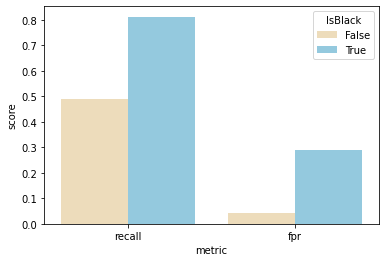

In [15]:
# Get scores for predominatly black areas
recall, fpr = equalized_odds(data_y.HighCrime.values[IsBlack], logreg_preds[IsBlack])
logreg_tmp_df_1 = pd.DataFrame({"metric":["recall", "fpr"], "score":[recall, fpr], "IsBlack":[True, True]})

# Get scores for non predominatly black areas
recall, fpr = equalized_odds(data_y.HighCrime.values[~IsBlack], logreg_preds[~IsBlack])
logreg_tmp_df_2 = pd.DataFrame({"metric":["recall", "fpr"], "score":[recall, fpr], "IsBlack":[False, False]})

# Concat results
logreg_tmp_df = pd.concat([logreg_tmp_df_1, logreg_tmp_df_2])

sns.barplot(data=logreg_tmp_df, x="metric", y="score", hue="IsBlack", palette=["wheat", "skyblue"])
plt.show()

In [16]:
print(accuracy_score(data_y.HighCrime.values[~IsBlack], logreg_preds[~IsBlack]))
print(accuracy_score(data_y.HighCrime.values[IsBlack], logreg_preds[IsBlack]))
print(classification_report(y, logreg_preds))

0.8921496698459281
0.7749603803486529
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      1411
           1       0.78      0.71      0.74       583

    accuracy                           0.86      1994
   macro avg       0.83      0.81      0.82      1994
weighted avg       0.85      0.86      0.85      1994



### Decision tree

In [17]:
X, y = data, data_y["HighCrime"]
IsBlack = data_full.IsBlack == 1
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [18]:
scaler = scaling_func(preprocessing.StandardScaler)

In [19]:
model = DecisionTreeClassifier
model_params = {"random_state":1}

dt_preds = test_model(model, X, y, kfold, scaler=scaler,model_params=model_params)

**Intermediate results**

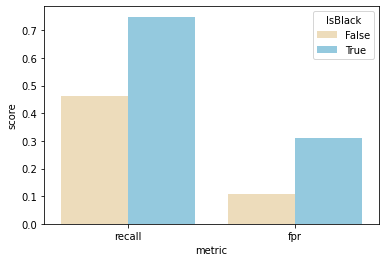

In [20]:
# Get scores for predominatly black areas
recall, fpr = equalized_odds(data_y.HighCrime.values[IsBlack], dt_preds[IsBlack])
dt_tmp_df_1 = pd.DataFrame({"metric":["recall", "fpr"], "score":[recall, fpr], "IsBlack":[True, True]})

# Get scores for non predominatly black areas
recall, fpr = equalized_odds(data_y.HighCrime.values[~IsBlack], dt_preds[~IsBlack])
dt_tmp_df_2 = pd.DataFrame({"metric":["recall", "fpr"], "score":[recall, fpr], "IsBlack":[False, False]})

# Concat results
dt_tmp_df = pd.concat([dt_tmp_df_1, dt_tmp_df_2])

sns.barplot(data=dt_tmp_df, x="metric", y="score", hue="IsBlack", palette=["wheat", "skyblue"])
plt.show()

In [21]:
print(accuracy_score(data_y.HighCrime.values[~IsBlack], dt_preds[~IsBlack]))
print(accuracy_score(data_y.HighCrime.values[IsBlack], dt_preds[IsBlack]))
print(classification_report(y, dt_preds))

0.8319882611885546
0.7274167987321711
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1411
           1       0.66      0.66      0.66       583

    accuracy                           0.80      1994
   macro avg       0.76      0.76      0.76      1994
weighted avg       0.80      0.80      0.80      1994



# Debias data, model performance

In [22]:
# Initialize X (with out the label or the index columns)
X, y = data_full.drop(columns=y_cols+index_cols), data_y["HighCrime"]

## Logreg

In [23]:
# Initialize the scaling and debiasing function
l_value = 0.0
scaler = debias_data(protected_cols, nonprotected_cols, lambda_=l_value)

In [24]:
model = LogisticRegression
model_params = {"random_state":1, "max_iter":500}

debias_logreg_preds = test_model(model, X, y, kfold, scaler=scaler,model_params=model_params)

**Intermediate results**

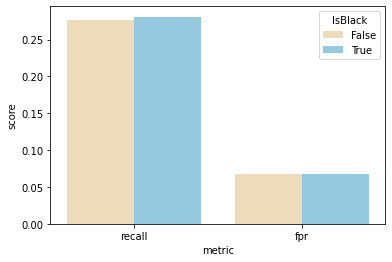

In [25]:
# Get scores for predominatly black areas
recall, fpr = equalized_odds(data_y.HighCrime.values[IsBlack], debias_logreg_preds[IsBlack])
debias_log_tmp_df_1 = pd.DataFrame({"metric":["recall", "fpr"], "score":[recall, fpr], "IsBlack":[True, True]})

# Get scores for non predominatly black areas
recall, fpr = equalized_odds(data_y.HighCrime.values[~IsBlack], debias_logreg_preds[~IsBlack])
debias_log_tmp_df_2 = pd.DataFrame({"metric":["recall", "fpr"], "score":[recall, fpr], "IsBlack":[False, False]})

# Concat results
logreg_tmp_df_reproject = pd.concat([debias_log_tmp_df_1, debias_log_tmp_df_2])

sns.barplot(data=logreg_tmp_df_reproject, x="metric", y="score", hue="IsBlack", palette=["wheat", "skyblue"])
plt.show()

In [26]:
print(accuracy_score(data_y.HighCrime.values[~IsBlack], debias_logreg_preds[~IsBlack]))
print(accuracy_score(data_y.HighCrime.values[IsBlack], debias_logreg_preds[IsBlack]))
print(classification_report(y, debias_logreg_preds))

0.8422597212032281
0.5245641838351822
              precision    recall  f1-score   support

           0       0.76      0.93      0.84      1411
           1       0.63      0.28      0.39       583

    accuracy                           0.74      1994
   macro avg       0.69      0.61      0.61      1994
weighted avg       0.72      0.74      0.71      1994



## Decision Tree

In [27]:
# Initialize the scaling and debiasing function
l_value = 0.0
scaler = debias_data(protected_cols, nonprotected_cols, lambda_=l_value)

In [28]:
model = DecisionTreeClassifier
model_params = {"random_state":1}

debias_dt_preds = test_model(model, X, y, kfold, scaler=scaler,model_params=model_params)

**Intermediate results**

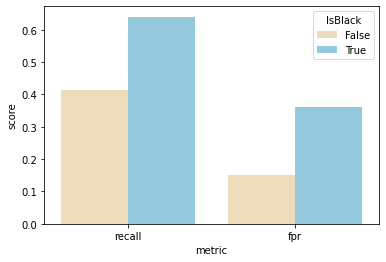

In [29]:
# Get scores for predominatly black areas
recall, fpr = equalized_odds(data_y.HighCrime.values[IsBlack], debias_dt_preds[IsBlack])
debias_dt_tmp_df_1 = pd.DataFrame({"metric":["recall", "fpr"], "score":[recall, fpr], "IsBlack":[True, True]})

# Get scores for non predominatly black areas
recall, fpr = equalized_odds(data_y.HighCrime.values[~IsBlack], debias_dt_preds[~IsBlack])
debias_dt_tmp_df_2 = pd.DataFrame({"metric":["recall", "fpr"], "score":[recall, fpr], "IsBlack":[False, False]})

# Concat results
dt_tmp_df_reproject = pd.concat([debias_dt_tmp_df_1, debias_dt_tmp_df_2])

sns.barplot(data=dt_tmp_df_reproject, x="metric", y="score", hue="IsBlack", palette=["wheat", "skyblue"])
plt.show()

In [30]:
print(accuracy_score(data_y.HighCrime.values[~IsBlack], debias_dt_preds[~IsBlack]))
print(accuracy_score(data_y.HighCrime.values[IsBlack], debias_dt_preds[IsBlack]))
print(classification_report(y, debias_dt_preds))

0.789435069699193
0.6402535657686212
              precision    recall  f1-score   support

           0       0.82      0.81      0.82      1411
           1       0.56      0.57      0.56       583

    accuracy                           0.74      1994
   macro avg       0.69      0.69      0.69      1994
weighted avg       0.74      0.74      0.74      1994



# Regular data vs. debias data

## Logreg

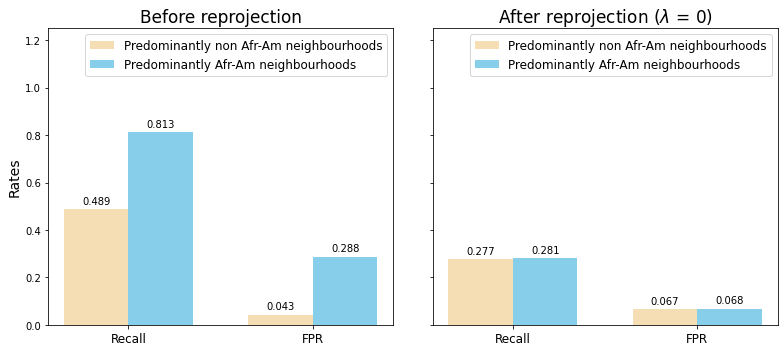

In [31]:
# Plot equalized odds for black vs non-black neighbourhoods

white_neig_eq_odds_before = np.round(logreg_tmp_df[logreg_tmp_df.IsBlack == 0].score.values,3)
black_neig_eq_odds_before = np.round(logreg_tmp_df[logreg_tmp_df.IsBlack == 1].score.values,3)

white_neig_eq_odds_after = np.round(logreg_tmp_df_reproject[logreg_tmp_df_reproject.IsBlack == 0].score.values,3)
black_neig_eq_odds_after = np.round(logreg_tmp_df_reproject[logreg_tmp_df_reproject.IsBlack == 1].score.values,3)


cols_for_hist = ["Recall", "FPR"]
x = np.arange(len(cols_for_hist))  # the label locations
width = 0.35  # the width of the bars

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (11,5), sharey = True)
rects1 = ax1.bar(x - width/2, white_neig_eq_odds_before, width, label='Predominantly non Afr-Am neighbourhoods', color = 'wheat')
rects2 = ax1.bar(x + width/2, black_neig_eq_odds_before, width, label='Predominantly Afr-Am neighbourhoods', color = "skyblue")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_ylabel('Rates', fontsize = 14)
ax1.set_title('Before reprojection', fontsize = 17)
ax1.set_xticks(x)
ax1.set_xticklabels(cols_for_hist, fontsize = 12)
ax1.set_ylim(top = 0.5)
ax1.legend(fontsize = 12)

autolabel(rects1, ax1)
autolabel(rects2, ax1)

# Plot equalized odds for black vs non-black neighbourhoods

rects1 = ax2.bar(x - width/2, white_neig_eq_odds_after, width, label='Predominantly non Afr-Am neighbourhoods', color = 'wheat')
rects2 = ax2.bar(x + width/2, black_neig_eq_odds_after, width, label='Predominantly Afr-Am neighbourhoods', color = "skyblue")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_title(f'After reprojection ($\lambda$ = 0)', fontsize = 17)
ax2.set_xticks(x)
ax2.set_xticklabels(cols_for_hist, fontsize = 12)
ax2.set_ylim(top = 1.25)
ax2.legend(fontsize = 12)

autolabel(rects1, ax2)
autolabel(rects2, ax2)

fig.tight_layout()

plt.savefig("Plots/eq_odds_before_after_reproject_logreg.png")


plt.show()

## Decision tree

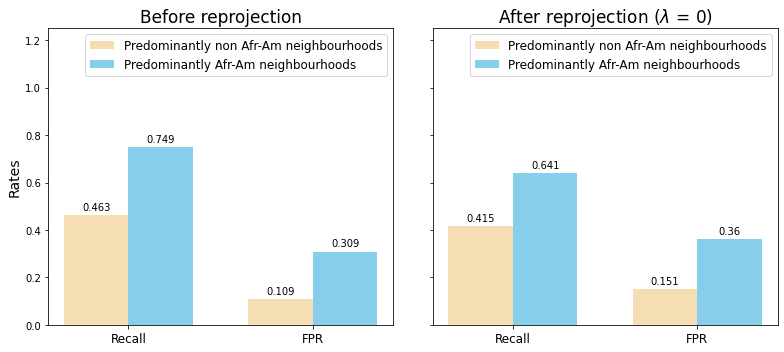

In [32]:
# Plot equalized odds for black vs non-black neighbourhoods

white_neig_eq_odds_before = np.round(dt_tmp_df[dt_tmp_df.IsBlack == 0].score.values,3)
black_neig_eq_odds_before = np.round(dt_tmp_df[dt_tmp_df.IsBlack == 1].score.values,3)

white_neig_eq_odds_after = np.round(dt_tmp_df_reproject[dt_tmp_df_reproject.IsBlack == 0].score.values,3)
black_neig_eq_odds_after = np.round(dt_tmp_df_reproject[dt_tmp_df_reproject.IsBlack == 1].score.values,3)


cols_for_hist = ["Recall", "FPR"]
x = np.arange(len(cols_for_hist))  # the label locations
width = 0.35  # the width of the bars

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (11,5), sharey = True)
rects1 = ax1.bar(x - width/2, white_neig_eq_odds_before, width, label='Predominantly non Afr-Am neighbourhoods', color = 'wheat')
rects2 = ax1.bar(x + width/2, black_neig_eq_odds_before, width, label='Predominantly Afr-Am neighbourhoods', color = "skyblue")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_ylabel('Rates', fontsize = 14)
ax1.set_title('Before reprojection', fontsize = 17)
ax1.set_xticks(x)
ax1.set_xticklabels(cols_for_hist, fontsize = 12)
ax1.set_ylim(top = 0.5)
ax1.legend(fontsize = 12)

autolabel(rects1, ax1)
autolabel(rects2, ax1)

# Plot equalized odds for black vs non-black neighbourhoods

rects1 = ax2.bar(x - width/2, white_neig_eq_odds_after, width, label='Predominantly non Afr-Am neighbourhoods', color = 'wheat')
rects2 = ax2.bar(x + width/2, black_neig_eq_odds_after, width, label='Predominantly Afr-Am neighbourhoods', color = "skyblue")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_title(f'After reprojection ($\lambda$ = 0)', fontsize = 17)
ax2.set_xticks(x)
ax2.set_xticklabels(cols_for_hist, fontsize = 12)
ax2.set_ylim(top = 1.25)
ax2.legend(fontsize = 12)

autolabel(rects1, ax2)
autolabel(rects2, ax2)

fig.tight_layout()

plt.savefig("Plots/eq_odds_before_after_reproject_dt.png")


plt.show()

# Model explainability analysis

# Hyper param tuning

# Debiasing data lambda tuning

### Logreg lambda tunning pareto front

In [33]:
# Initialize X (with out the label or the index columns)
X, y = data_full.drop(columns=y_cols+index_cols), data_y["HighCrime"]

In [34]:
lambda_values = np.linspace(1,0,30)

In [35]:
predictions = {}
result_metrics = {}
for l_value in tqdm(lambda_values):
    scaler = debias_data(protected_cols, nonprotected_cols, lambda_=l_value)
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    model = LogisticRegression
    model_params = {"max_iter":500, "random_state":1}

    preds = test_model(model, X, y, kfold,scaler=scaler, model_params=model_params)
    predictions[f"{l_value:.2f}"] = preds
    
    acc_black = accuracy_score(data_y.HighCrime.values[IsBlack], preds[IsBlack])
    acc_non_black = accuracy_score(data_y.HighCrime.values[~IsBlack], preds[~IsBlack])
    recall_black, fpr_black = equalized_odds(data_y.HighCrime.values[IsBlack], preds[IsBlack])
    recall_non_black, fpr_non_black = equalized_odds(data_y.HighCrime.values[~IsBlack], preds[~IsBlack])
    num_high_black = np.sum(data_y.HighCrime.values[IsBlack]), np.sum(preds[IsBlack])
    num_highn_non_black = np.sum(data_y.HighCrime.values[~IsBlack]), np.sum(preds[~IsBlack])
    result_metrics[f"{l_value:.2f}"] = {"acc_black":acc_black,
                                        "acc_non_black": acc_non_black,
                                        "recall_black":recall_black, 
                                        "recall_non_black":recall_non_black,
                                         "fpr_black": fpr_black,
                                         "fpr_non_black": fpr_non_black,
                                        "num_high_black":num_high_black,
                                       "num_highn_non_black":num_highn_non_black}

100%|██████████████████████████████████████████████| 30/30 [01:52<00:00,  3.75s/it]


In [36]:
makro_acc = []
equal_odds_mse = []
for key, res in result_metrics.items():
    m_acc = (res["acc_black"] + res["acc_non_black"])/2
    se_recall = (res["recall_black"] - res["recall_non_black"])**2
    se_fpr = (res["fpr_black"] - res["fpr_non_black"])**2
    mse_total = (se_recall + se_fpr)/2
    
    makro_acc.append(m_acc)
    equal_odds_mse.append(mse_total)

In [37]:
annotate_ax = [0, 7, 12, 18, 20, 23, 25, 29]
y_upper = [x + 10 for x in equal_odds_mse]

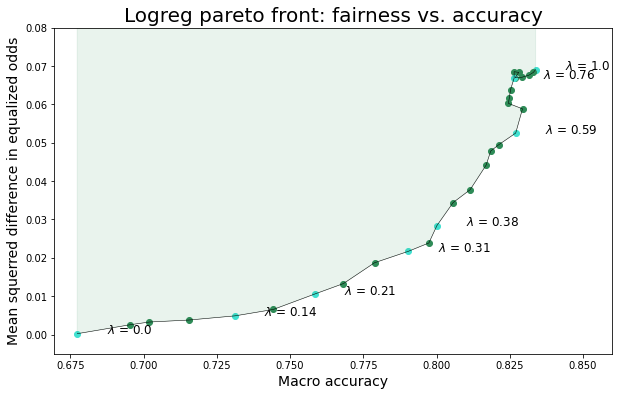

In [38]:
fig, ax = plt.subplots(1, figsize=(10,6))

ax.plot(makro_acc, equal_odds_mse, color = "black", linewidth = 0.5)

for j in np.arange(0,len(lambda_values),1):
    if j in annotate_ax:
        color = 'turquoise'
    else: 
        color = 'seagreen'
    ax.scatter(makro_acc[j], equal_odds_mse[j], color = color)

for i in annotate_ax:
    ax.annotate("$\lambda$ = "+str(np.round(lambda_values[i],2)), (makro_acc[i] + 0.01, equal_odds_mse[i]), fontsize = 12)

ax.fill_between(makro_acc, equal_odds_mse, y_upper, color = "seagreen", alpha = 0.1)

ax.set_xlim(right = 0.86)
ax.set_ylim(bottom = -0.005, top = 0.08)

plt.title("Logreg pareto front: fairness vs. accuracy", fontsize = 20)
plt.xlabel(r"Macro accuracy", fontsize = 14)
plt.ylabel("Mean squerred difference in equalized odds", fontsize = 14)

plt.savefig("Plots/logreg_pareto.png")


plt.show()

## Decision tree lambda tunning pareto front

In [39]:
predictions = {}
result_metrics = {}
for l_value in tqdm(lambda_values):
    scaler = debias_data(protected_cols, nonprotected_cols, lambda_=l_value)
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    model = DecisionTreeClassifier
    model_params = {"random_state":1}

    preds = test_model(model, X, y, kfold,scaler=scaler, model_params=model_params)
    predictions[f"{l_value:.2f}"] = preds
    
    acc_black = accuracy_score(data_y.HighCrime.values[IsBlack], preds[IsBlack])
    acc_non_black = accuracy_score(data_y.HighCrime.values[~IsBlack], preds[~IsBlack])
    recall_black, fpr_black = equalized_odds(data_y.HighCrime.values[IsBlack], preds[IsBlack])
    recall_non_black, fpr_non_black = equalized_odds(data_y.HighCrime.values[~IsBlack], preds[~IsBlack])
    num_high_black = np.sum(data_y.HighCrime.values[IsBlack]), np.sum(preds[IsBlack])
    num_highn_non_black = np.sum(data_y.HighCrime.values[~IsBlack]), np.sum(preds[~IsBlack])
    result_metrics[f"{l_value:.2f}"] = {"acc_black":acc_black,
                                        "acc_non_black": acc_non_black,
                                        "recall_black":recall_black, 
                                        "recall_non_black":recall_non_black,
                                         "fpr_black": fpr_black,
                                         "fpr_non_black": fpr_non_black,
                                        "num_high_black":num_high_black,
                                       "num_highn_non_black":num_highn_non_black}

100%|██████████████████████████████████████████████| 30/30 [01:53<00:00,  3.79s/it]


In [40]:
makro_acc = []
equal_odds_mse = []
for key, res in result_metrics.items():
    m_acc = (res["acc_black"] + res["acc_non_black"])/2
    se_recall = (res["recall_black"]- res["recall_non_black"])**2
    se_fpr = (res["fpr_black"] - res["fpr_non_black"])**2
    mse_total = (se_recall + se_fpr)/2
    
    makro_acc.append(m_acc)
    equal_odds_mse.append(mse_total)

In [41]:
annotate_ax = [0, 7, 12, 18, 20, 23, 25, 29]
y_upper = [x + 10 for x in equal_odds_mse]

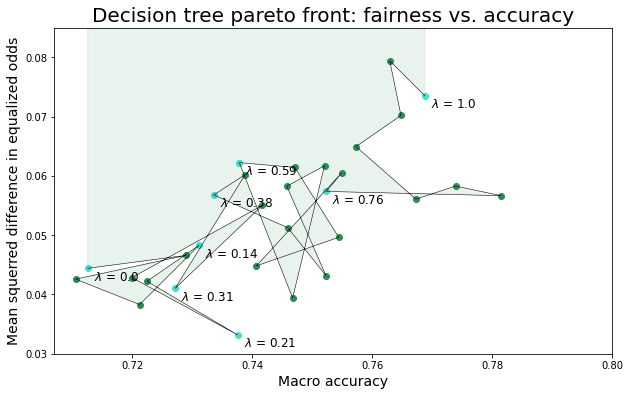

In [42]:
fig, ax = plt.subplots(1, figsize=(10,6))

ax.plot(makro_acc, equal_odds_mse, color = "black", linewidth = 0.5)

for j in np.arange(0,len(lambda_values),1):
    if j in annotate_ax:
        color = 'turquoise'
    else: 
        color = 'seagreen'
    ax.scatter(makro_acc[j], equal_odds_mse[j], color = color)

for i in annotate_ax:
    ax.annotate("$\lambda$ = "+str(np.round(lambda_values[i],2)), (makro_acc[i] + 0.001, equal_odds_mse[i]-0.002), fontsize = 12)

ax.fill_between(makro_acc, equal_odds_mse, y_upper, color = "seagreen", alpha = 0.1)

ax.set_xlim(right = 0.8)
ax.set_ylim(bottom = 0.03, top = 0.085)

plt.title("Decision tree pareto front: fairness vs. accuracy", fontsize = 20)
plt.xlabel(r"Macro accuracy", fontsize = 14)
plt.ylabel("Mean squerred difference in equalized odds", fontsize = 14)

plt.savefig("Plots/tree_pareto.png")


plt.show()

# Correlation analysis

In [43]:
colors = ["orangered", "wheat", "deepskyblue"]
cmap = LinearSegmentedColormap.from_list("cmap_name", colors, N=50)

In [44]:
# Most important features
dt_raw = ["PctIlleg", "NumIlleg", "PctPopUnderPov", "PctKids2Par", "PctNotSpeakEnglWell", "householdsize"]

dt_debias = ["PctIlleg", "MedNumBR", "PctPersDenseHous", "NumIlleg", "PctNotSpeakEnglWell", "pctWSocSec"]

logreg_raw = ["PctIlleg", "PctHousOccup", "HousVacant", "MedOwnCostPctIncNoMtg", "MedRentPctHousInc", "pctWInvInc", "PctPopUnderPov", "PctWorkMom"]
logreg_debias = ["whitePerCap", "PctKids2Par", "PctIlleg", "PctPersDenseHous", "perCapInc", "PersPerFam", "PctNotSpeakEnglWell", "PctSpeakEnglOnly", "MedRent", "PctRecImmig10"]
most_important_featureas = list(set(logreg_raw + logreg_raw + dt_raw + dt_debias))

In [45]:
len(most_important_featureas)

15

In [46]:
X, y = data_full.drop(columns=y_cols+index_cols), data_y["HighCrime"]
org_df = X.copy()
org_df[y_cols] = data_y.copy()

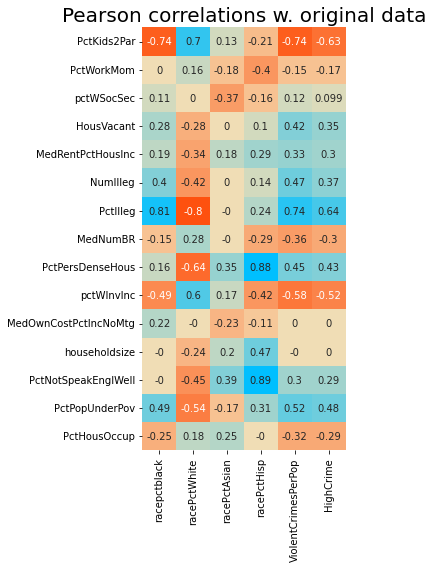

In [47]:
# Same, just showing the protected columns
fig, ax = plt.subplots(1, figsize=(5,8))
sns.heatmap(get_significant_correlations(org_df)[protected_cols + y_cols].loc[most_important_featureas], center=0, annot=True, cmap=cmap, cbar=False)
plt.title("Pearson correlations w. original data", fontsize = 20)

plt.tight_layout()
plt.savefig("Plots/pcorr_org_data_important_features.png")


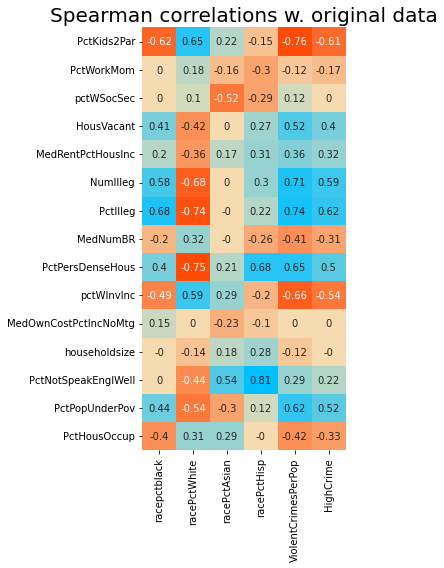

In [48]:
# Spearman
# Same, just showing the protected columns
fig, ax = plt.subplots(1, figsize=(5,8))
sns.heatmap(get_significant_correlations(org_df, method="spearman")[protected_cols + y_cols].loc[most_important_featureas], center=0, annot=True, cmap=cmap, cbar=False)
plt.title("Spearman correlations w. original data", fontsize = 20)

plt.tight_layout()
plt.savefig("Plots/scorr_org_data_important_features.png")

## Debiased data corrs

In [49]:
debias_df = data_full.copy().drop(columns=y_cols)
debias_array, _ = debias_data(protected_cols, nonprotected_cols)(debias_df, debias_df)

In [50]:
# Add the protected columns and the target columns to the debiased data frame for comparison
debias_df = pd.DataFrame(debias_array, columns=nonprotected_cols)
debias_df[y_cols] = data_y
debias_df[protected_cols] = data_full[protected_cols]

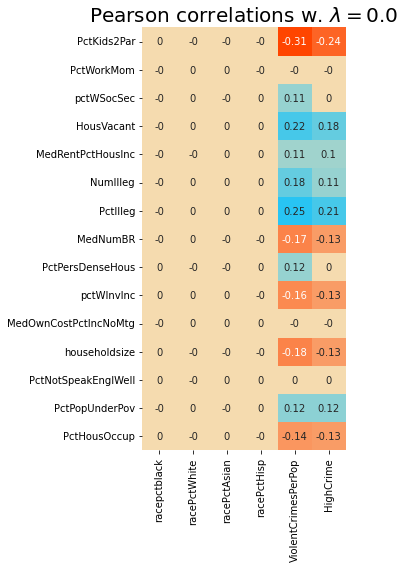

In [51]:
# Show the pearson correlations
pearson_corr = get_significant_correlations(debias_df, cluster=False)
fig, ax = plt.subplots(1, figsize=(5,8))
sns.heatmap(pearson_corr[protected_cols + y_cols].loc[most_important_featureas], center=0, annot=True, cmap=cmap, cbar=False)
plt.title("Pearson correlations w. $\lambda=0.0$", fontsize = 20)

plt.tight_layout()
plt.savefig("Plots/pcorr_debias_data_important_features.png")

In [52]:
# Speanman corr matrix
speaman_corr = get_significant_correlations(debias_df, cluster=False, method="spearman")

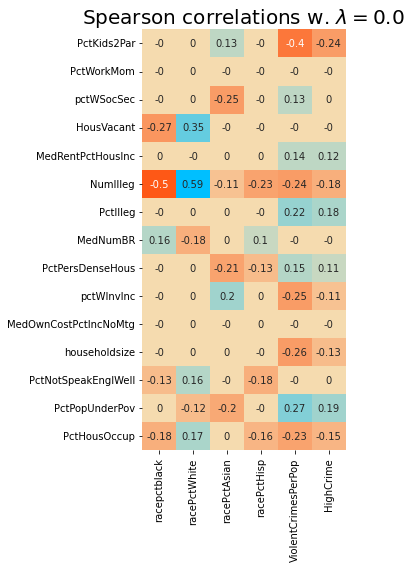

In [53]:
fig, ax = plt.subplots(1, figsize=(5,8))
sns.heatmap(speaman_corr[protected_cols + y_cols].loc[most_important_featureas], center=0, annot=True, cmap=cmap, cbar=False)
plt.title("Spearson correlations w. $\lambda=0.0$", fontsize = 20)

plt.tight_layout()
plt.savefig("Plots/scorr_debias_data_important_features.png")

# Lambda loop correlations
Looking at the correlation between the protected features and debiased data, with different lambdas.

Purpose is to showcase the effect of lambda and how at lambda 0, there should be no pearsons correlations

In [54]:
# Initialize X (with out the label or the index columns)
X, y = data_full.drop(columns=y_cols+index_cols), data_y["HighCrime"]

In [55]:
lambda_values = np.linspace(1,0,10)

In [56]:
data_sets = {}
for l_value in tqdm(lambda_values):
    scaler = debias_data(protected_cols, nonprotected_cols, lambda_=l_value)
    db, _ = scaler(X, X)
    data_sets[f"{l_value:.2f}"] = db
    

100%|██████████████████████████████████████████████| 10/10 [00:22<00:00,  2.25s/it]


In [57]:
lambda_res = data_full[protected_cols + y_cols]

In [58]:
lambda_res = data_full[protected_cols + y_cols]
com_col = "NumIlleg"
lambda_cols = []
for col in data_sets.keys():
    tmp_df = pd.DataFrame(data_sets[col], columns=[col for col in X.columns if col not in protected_cols])
    lambda_res[f"l{col}_{com_col}"] = tmp_df[com_col]
    lambda_cols.append(f"l{col}_{com_col}")

/var/folders/bx/2b_70g054qg3qt5jhnw30xv40000gn/T/ipykernel_5811/1644855374.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lambda_res[f"l{col}_{com_col}"] = tmp_df[com_col]


<AxesSubplot:>

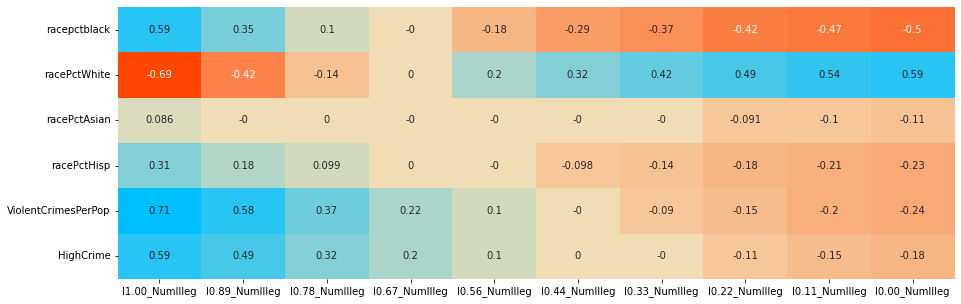

In [59]:
# Speanman corr matrix
speaman_corr = get_significant_correlations(lambda_res, cluster=False, method="spearman")
fig, ax = plt.subplots(1, figsize=(15,5))
sns.heatmap(speaman_corr[protected_cols + y_cols].T[lambda_cols], center=0, annot=True, cmap=cmap, cbar=False)


<AxesSubplot:>

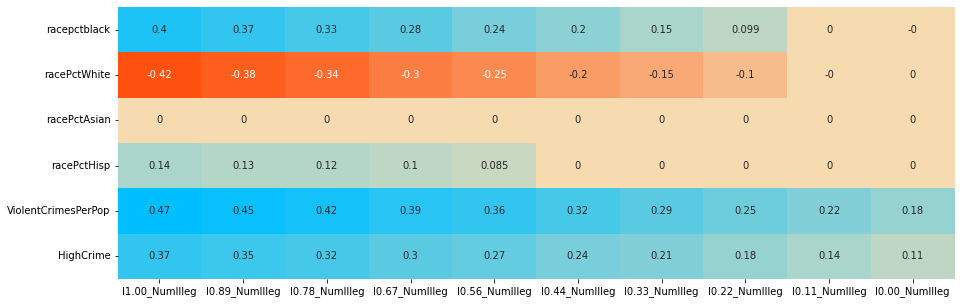

In [60]:
# Pearson corr matrix
pearson_corr = get_significant_correlations(lambda_res, cluster=False, method="pearson")
fig, ax = plt.subplots(1, figsize=(15,5))
sns.heatmap(pearson_corr[protected_cols + y_cols].T[lambda_cols], center=0, annot=True, cmap=cmap, cbar=False)


## Comparing racepct black with all debiased features, w. different lambda

In [61]:
protected_col = "racepctblack"
protected_small_df = data_full[[protected_col]]
pearson_df = pd.DataFrame()
spearman_df = pd.DataFrame()
lambda_cols = []
for col in tqdm(data_sets.keys()):
    tmp_df = pd.DataFrame(data_sets[col], columns=[col for col in X.columns if col not in protected_cols])
    tmp_df = tmp_df.merge(protected_small_df, left_index=True, right_index=True)
    spearman_corr = get_significant_correlations(tmp_df, cluster=False, method="spearman")
    spearman_df[f"l{col}_{protected_col}"] = spearman_corr[[protected_col]]
    pearson_corr = get_significant_correlations(tmp_df, cluster=False, method="pearson")
    pearson_df[f"l{col}_{protected_col}"] = pearson_corr[[protected_col]]
    

100%|██████████████████████████████████████████████| 10/10 [00:46<00:00,  4.69s/it]


### Pearsons correlations between racepctblack and the debiased data with different lambda

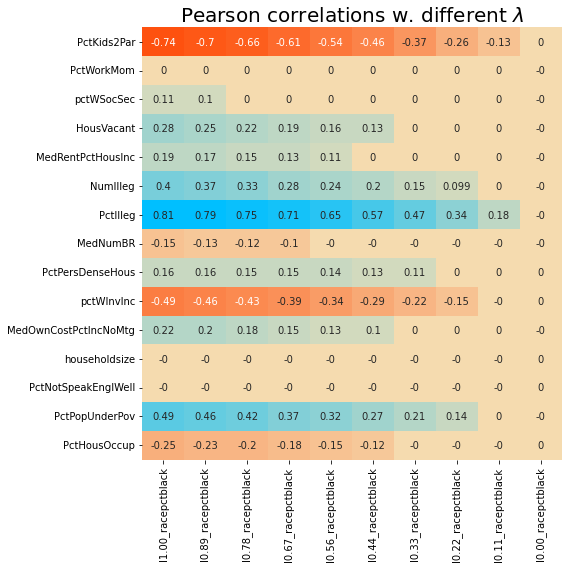

In [62]:
# All columns
fig, ax = plt.subplots(1, figsize=(8,8))
sns.heatmap(pearson_df.loc[most_important_featureas], center=0, annot=True, cmap=cmap, cbar=False)
plt.title("Pearson correlations w. different $\lambda$", fontsize = 20)

plt.tight_layout()
plt.savefig("Plots/pcorr_debias_lambdas_important_features.png")

### Spearman correlations between racepctblack and the debiased data with different lambda

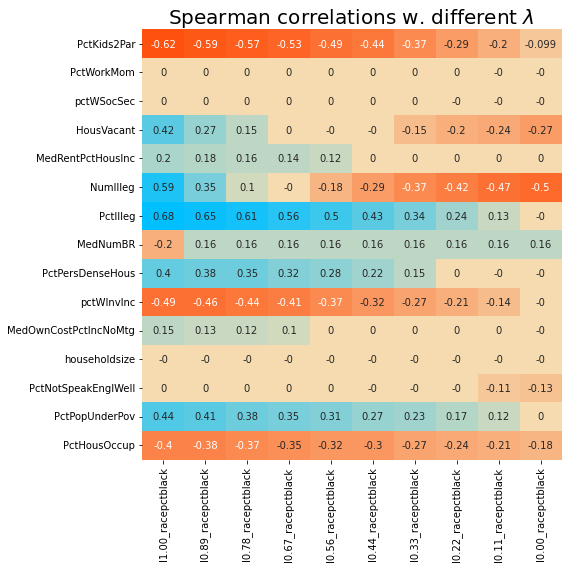

In [63]:
# Most important features
fig, ax = plt.subplots(1, figsize=(8,8))
sns.heatmap(spearman_df.loc[most_important_featureas], center=0, annot=True, cmap=cmap, cbar=False)
plt.title("Spearman correlations w. different $\lambda$", fontsize = 20)

plt.tight_layout()
plt.savefig("Plots/scorr_debias_lambdas_important_features.png")